In [ ]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        self.flatten = nn.Flatten()
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
        )

    def forward(self, x):
        #print(x.shape)
        x = self.flatten(x)
        #print(x.shape)
        logits = self.linear_relu_stack(x)
        return logits

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor() 
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_data, val_data = train_test_split(training_data, test_size=0.2, random_state=42)
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=True)

model = NeuralNetwork()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3) 

def switch_grad_mode(model: nn.Module , requires_grad: bool=True):
    for param in model.parameters():
        param.requires_grad = requires_grad


def switch_model_mode(model: nn.Module, train: bool=True):
    if train:
        model.train()
    else:
        model.eval()


def train(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    model = model.to(device)
    losses = []
    accuracies = []
    # перед обучением не забываем перевести модель в режим train, чтобы она обновляла веса
    switch_grad_mode(model, True)
    switch_model_mode(model, True)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device) # перекидываем батчи на нужное устройство

        # Вычисляем лосс
        pred = model(X) # делаем проход по функции forward
        loss = loss_fn(pred, y)

        # Теперь весь страшный алгоритм backprop, который был на лекции, скрыт от нас
        optimizer.zero_grad() # перед тем как считать новые градиенты, стираем градиенты с предыдущей итерации обучения
        loss.backward() # считаем градиенты
        optimizer.step() # посчитав градиент, просим оптимизатор обновить аргументы

        loss, current = loss.item(), batch * len(X)
        if batch % 100 == 0:
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        losses.append(loss)
    return sum(losses)/len(dataloader)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:

def test(dataloader, model, loss_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    # переводим модель в режим тестирования
    # если вы используете валидацию, там нужно сделать то же самое
    switch_grad_mode(model, requires_grad=False)
    switch_model_mode(model, train=False)
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        test_loss += loss_fn(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

def validate(dataloader, model, loss_fn, device):
   size = len(dataloader.dataset)
   num_batches = len(dataloader)
   val_loss, loss, correct = 0, 0, 0
   # переводим модель в режим тестирования
   # если вы используете валидацию, там нужно сделать то же самое
   switch_grad_mode(model, requires_grad=False)
   switch_model_mode(model, train=False)
   for X, y in dataloader:
       X, y = X.to(device), y.to(device)
       pred = model(X)
       val_loss += loss_fn(pred, y).item()
       correct = (pred.argmax(1) == y).type(torch.float).sum().item()
   val_loss /= num_batches
   correct /= size
   accuracy = 100*correct
   print(f"Validation: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {val_loss:>8f} \n")
   return correct, accuracy, val_loss

In [ ]:
epochs = 20
best_accuracy = 0
current_accuracy = 0
accuracies = []
losses = []
train_losses = []
device = torch.device("cuda")
min_val_loss = np.inf
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer, device)
    train_losses.append(train_loss)
    if t % 10 == 0:
      current_accuracy, acc, loss = validate(val_dataloader, model, loss_fn, device)
      accuracies.append(acc)
      losses.append(loss)
      if(current_accuracy > best_accuracy):
        torch.save(model.state_dict(), 'model_weights.pth') 
        best_accuracy = current_accuracy
print("Done!")
test(test_dataloader, model, loss_fn, device)

Epoch 1
-------------------------------
loss: 4.184349  [    0/48000]
loss: 4.175668  [ 6400/48000]
loss: 4.145288  [12800/48000]
loss: 4.120534  [19200/48000]
loss: 4.107898  [25600/48000]
loss: 4.074627  [32000/48000]
loss: 4.052916  [38400/48000]
loss: 4.017740  [44800/48000]
Validation: 
 Accuracy: 0.0%, Avg loss: 4.003694 

Epoch 2
-------------------------------
loss: 3.998244  [    0/48000]
loss: 3.957476  [ 6400/48000]
loss: 3.898264  [12800/48000]
loss: 3.828810  [19200/48000]
loss: 3.641491  [25600/48000]
loss: 3.503660  [32000/48000]
loss: 3.263271  [38400/48000]
loss: 2.861275  [44800/48000]
Epoch 3
-------------------------------
loss: 2.697807  [    0/48000]
loss: 2.503839  [ 6400/48000]
loss: 2.514107  [12800/48000]
loss: 2.367847  [19200/48000]
loss: 2.362866  [25600/48000]
loss: 2.329137  [32000/48000]
loss: 2.430146  [38400/48000]
loss: 2.400634  [44800/48000]
Epoch 4
-------------------------------
loss: 2.340314  [    0/48000]
loss: 2.321997  [ 6400/48000]
loss: 2.2

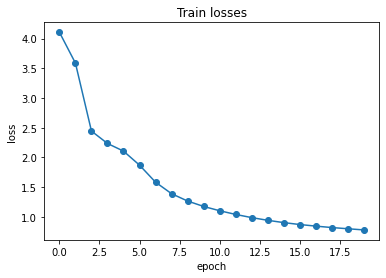

In [ ]:
plt.plot(train_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Train losses')
 
plt.show()

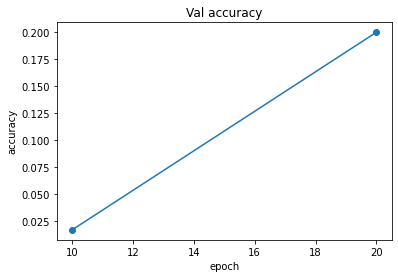

In [ ]:
plt.plot([10, 20], accuracies, '-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Val accuracy')
 
plt.show()

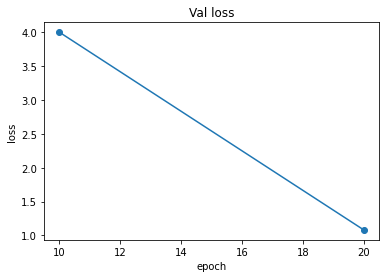

In [ ]:
plt.plot([10, 20], losses, '-o')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Val loss')
 
plt.show()